In [1]:
import pandas as pd
import numpy as np

In [19]:
df= pd.read_csv("./data/creditcard(1).csv")

In [20]:
df.head(1)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0


In [21]:
y = df.pop('Class')

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train , X_test, y_train , y_test = train_test_split(df, y, random_state=42, stratify=y)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [24]:
X_train.drop('Time', axis=1, inplace=True)
X_test.drop('Time', axis=1, inplace=True)

In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [11]:
ss = StandardScaler()
ss_amount = ss.fit_transform(X_train[['Amount']])
display(pd.DataFrame(ss_amount).describe()) # 이상값에 영향을 크게  받는다.

,0
count,2.136050e+05
mean,-4.217917e-17
std,1.000002e+00
min,-3.521314e-01
25%,-3.296184e-01
50%,-2.643147e-01
75%,-4.277697e-02
max,1.021985e+02


In [12]:
mm = MinMaxScaler()
mm_amount = mm.fit_transform(X_train[['Amount']])
display(pd.DataFrame(mm_amount).describe())  # 이상치에 영향을 받는다.

,0
count,213605.000000
mean,0.003434
std,0.009751
min,0.000000
25%,0.000220
50%,0.000856
75%,0.003017
max,1.000000


In [16]:
# 로그변화도 scaler 할 수 있다
# 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법중 하나
# 원래 값을 log 값을 변환해 원래 큰 값을 상대적으로 작은 값으로 변환하기 때문에 데이터 분포도의 왜곡을 상당 수준 개선해 줄 수 있다.
log_amount = (np.log1p(X_train[['Amount']]))
log_amount.boxplot()

<Axes: >

실험1: 현재 데이터(scaler 적용)로 로지스틱 회귀

In [26]:
ss = StandardScaler()
ss.fit(X_train)
X_train_scaler = ss.transform(X_train)

# ss2.fit(X_test)
X_test_scaler = ss.transform(X_test)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_scaler, y_train)

LogisticRegression()

In [27]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_test, lr.predict(X_test_scaler).reshape(-1, 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.84      0.62      0.71       123

    accuracy                           1.00     71202
   macro avg       0.92      0.81      0.86     71202
weighted avg       1.00      1.00      1.00     71202



실험 2 : 현재 데이터로 tree 계열 모델 학습 및 테스트

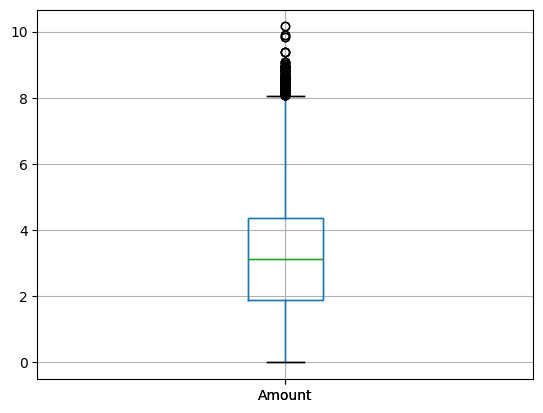

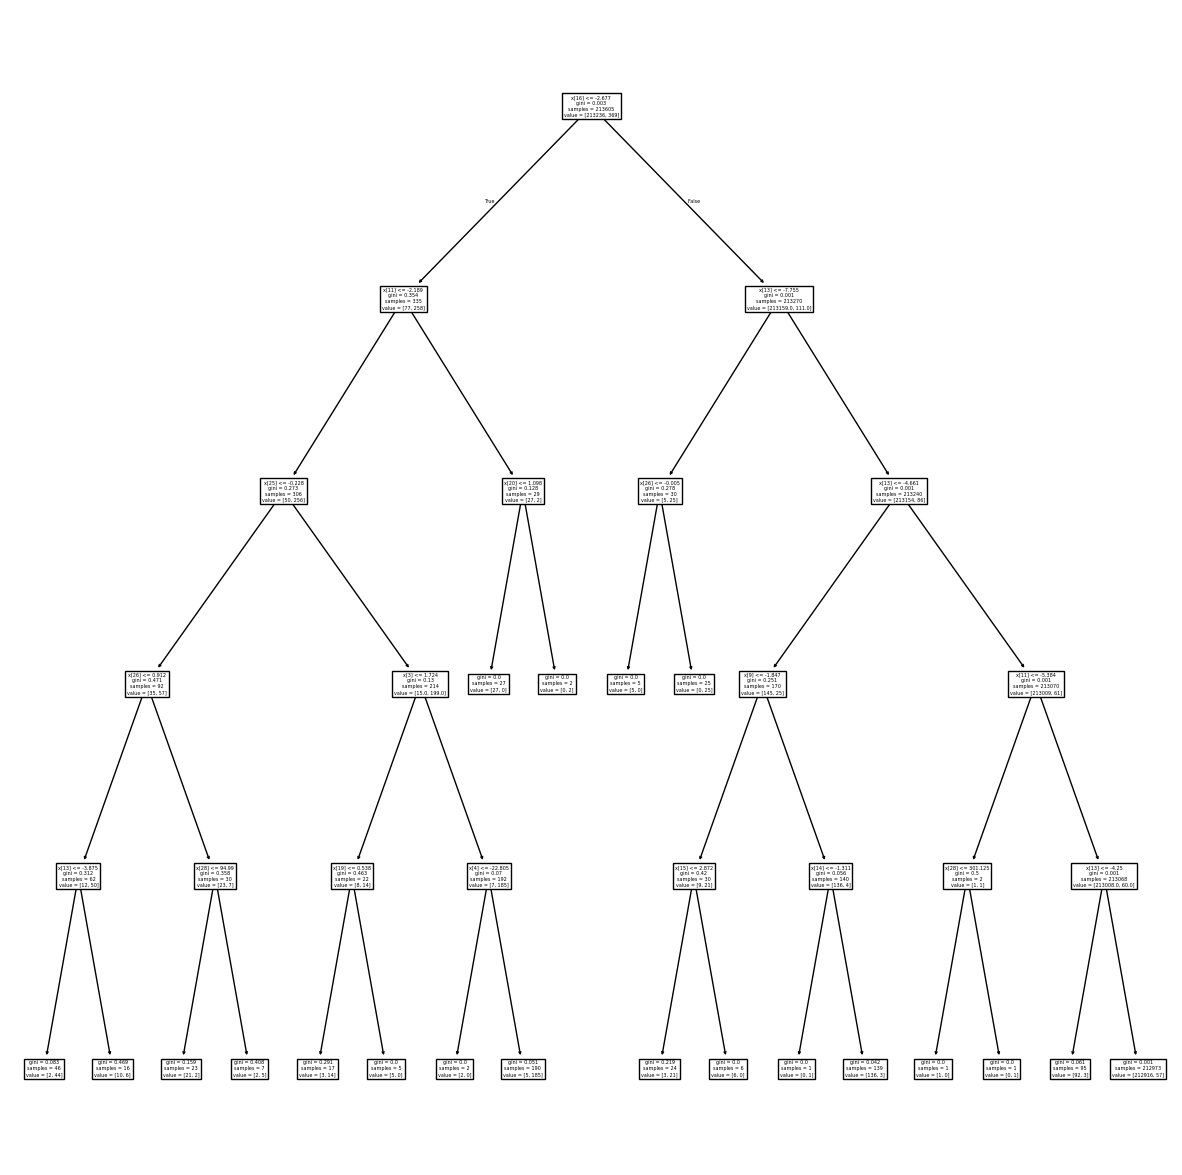

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.90      0.76      0.83       123

    accuracy                           1.00     71202
   macro avg       0.95      0.88      0.91     71202
weighted avg       1.00      1.00      1.00     71202



Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

In [30]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5)

dt.fit(X_train, y_train)

print(classification_report(y_test, dt.predict(X_test).reshape(-1, 1)))

y_test.value_counts(normalize=True)

실험 3: 이상치 제거 후 모델 생성 및 테스트

In [32]:
q1 = np.percentile(X_train.Amount, 25)
q3 = np.percentile(X_train.Amount, 75)
iqr = q3 -q1

In [33]:
lowest = q1 - (iqr * 1.5)
highest = q3 + (iqr * 1.5)

In [34]:
remove_index = X_train[(X_train.Amount < lowest) |  (X_train.Amount > highest)].index

In [36]:
X_train_remove = X_train[~X_train.index.isin(remove_index)].copy()
y_train_remove = y_train[~y_train.index.isin(remove_index)].copy()

In [37]:
dt = DecisionTreeClassifier(max_depth=5)

dt.fit(X_train_remove, y_train_remove)

DecisionTreeClassifier(max_depth=5)

In [38]:
print(classification_report(y_test, dt.predict(X_test).reshape(-1, 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.87      0.78      0.82       123

    accuracy                           1.00     71202
   macro avg       0.94      0.89      0.91     71202
weighted avg       1.00      1.00      1.00     71202



실험 4: SMOTE으로 over sampling 진행후 모델 생성 및 테스트

In [39]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [40]:
# 샘플링 종류 = 언더 샘플링, 오버 샘플링
y_train_over.value_counts()  # 오버 샘플링

Class
0    213236
1    213236
Name: count, dtype: int64

In [41]:
lr = LogisticRegression()
lr.fit(X_train_over, y_train_over)

/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [42]:
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71079
           1       0.07      0.89      0.14       123

    accuracy                           0.98     71202
   macro avg       0.54      0.93      0.56     71202
weighted avg       1.00      0.98      0.99     71202

